<h1> Прогноз оттока клиентов </h1>

### **Описание проекта: телекоммуникации**  
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.  
**Описание услуг**  
Оператор предоставляет два основных типа услуг: Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.  
Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).  
Также доступны такие услуги: Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
Выделенная линия технической поддержки (TechSupport);
Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).    
За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Цель проекта:  
Нужно выявить клиентов собирающиеся отказаться от наших услуг. Этим клиентам будут предложены промокоды и специальные условия, чтобы сохранить их. 

In [1]:
!pip install phik

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from catboost import cv, Pool

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [5]:
from sklearn.metrics import roc_auc_score, roc_curve
import phik
from phik import phik_matrix

In [6]:
from sklearn.metrics import plot_roc_curve

In [7]:
RANDOM_STATE = 30723

In [8]:
try:
    personal = pd.read_csv('/datasets/personal_new.csv')
    contract = pd.read_csv('/datasets/contract_new.csv')
    phone = pd.read_csv('/datasets/phone_new.csv')
    internet = pd.read_csv('/datasets/internet_new.csv')
except FileNotFoundError:
    try:
        personal = pd.read_csv('C:/Users/purfo/personal_new.csv')
        contract = pd.read_csv('C:/Users/purfo/contract_new.csv')
        phone = pd.read_csv('C:/Users/purfo/phone_new.csv')
        internet = pd.read_csv('C:/Users/purfo/internet_new.csv')
    except FileNotFoundError:
            pass

Описание данных  
Данные состоят из файлов, полученных из разных источников:  
• contract_new.csv — информация о договоре;  
• personal_new.csv — персональные данные клиента;  
• internet_new.csv — информация об интернет-услугах;  
• phone_new.csv — информация об услугах телефонии  

In [9]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [10]:
personal.info(), personal.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


(None,
        SeniorCitizen
 count    7043.000000
 mean        0.162147
 std         0.368612
 min         0.000000
 25%         0.000000
 50%         0.000000
 75%         0.000000
 max         1.000000)

In [11]:
personal.isna().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

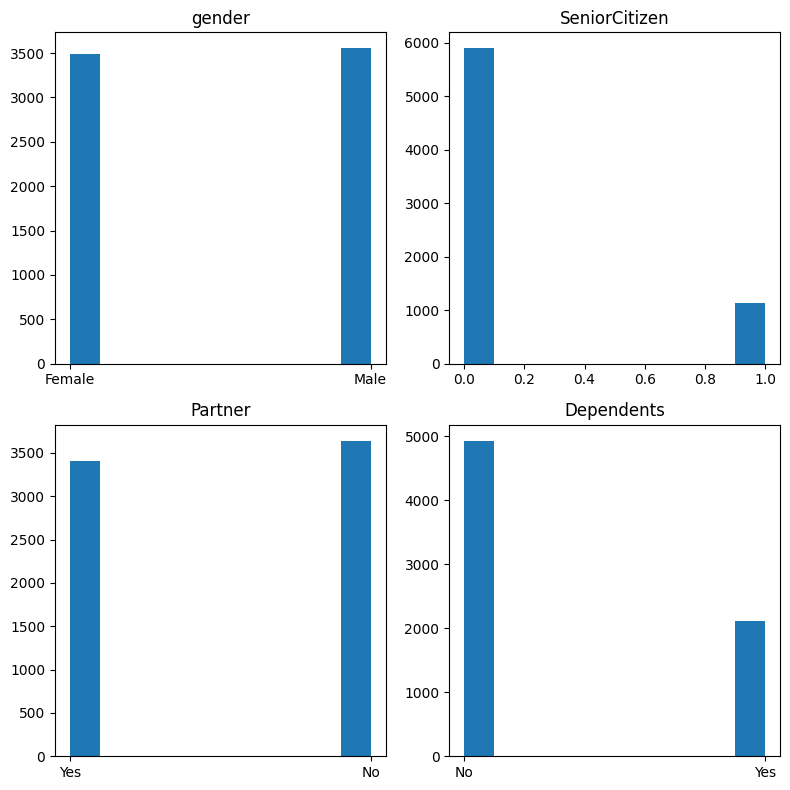

In [12]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
axs = axs.flatten()

for i, column in enumerate(personal.iloc[:, 1:].columns):
    axs[i].hist(personal[column])
    axs[i].set_title(column)

plt.tight_layout()
plt.show()

В датасете personal 7043 строки и 5 столбца, 4 object и 1 int64.  
Почему то в SeniorCitizen использовали 0-1, хотя в других случаях yes-no. 

In [13]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [14]:
contract.info(), contract.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


(None,
        MonthlyCharges
 count     7043.000000
 mean        64.761692
 std         30.090047
 min         18.250000
 25%         35.500000
 50%         70.350000
 75%         89.850000
 max        118.750000)

In [15]:
contract.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [16]:
contract['TotalCharges'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 7043 entries, 0 to 7042
Series name: TotalCharges
Non-Null Count  Dtype 
--------------  ----- 
7043 non-null   object
dtypes: object(1)
memory usage: 55.1+ KB


In [17]:
contract[contract['TotalCharges'] == ' '].count()
# неявные пропуски

customerID          11
BeginDate           11
EndDate             11
Type                11
PaperlessBilling    11
PaymentMethod       11
MonthlyCharges      11
TotalCharges        11
dtype: int64

In [18]:
contract['TotalCharges'] = contract['TotalCharges'].replace(' ', 'Nan')

In [19]:
contract['TotalCharges'] = contract['TotalCharges'].astype('float64')

In [20]:
contract['TotalCharges'] = contract['TotalCharges'].fillna(contract['TotalCharges'].mean())

In [21]:
contract['TotalCharges'] = contract['TotalCharges'].astype('int64')

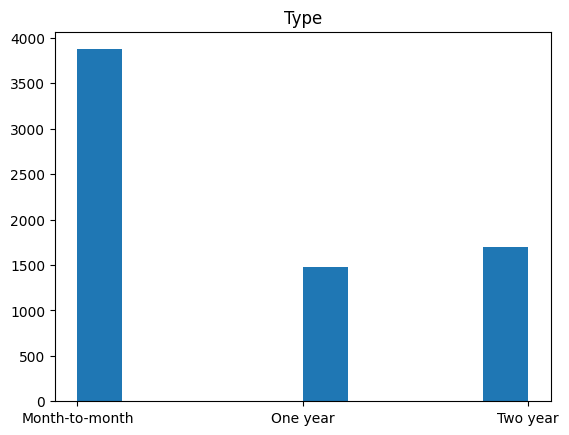

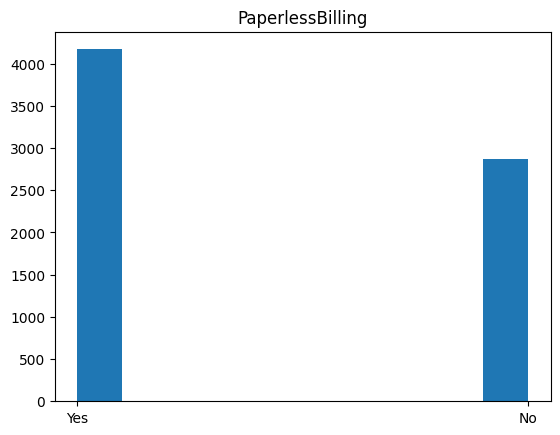

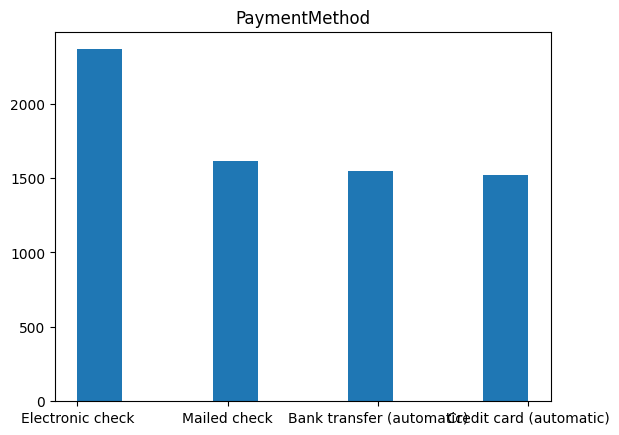

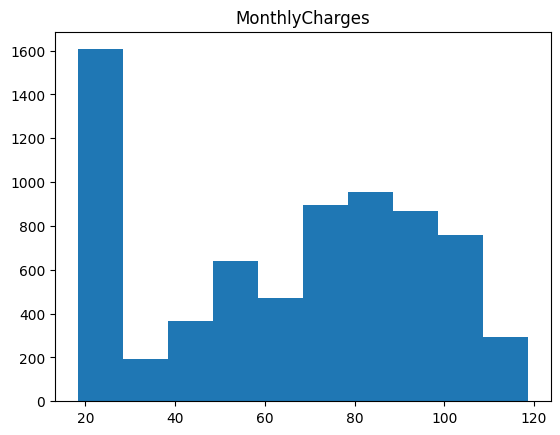

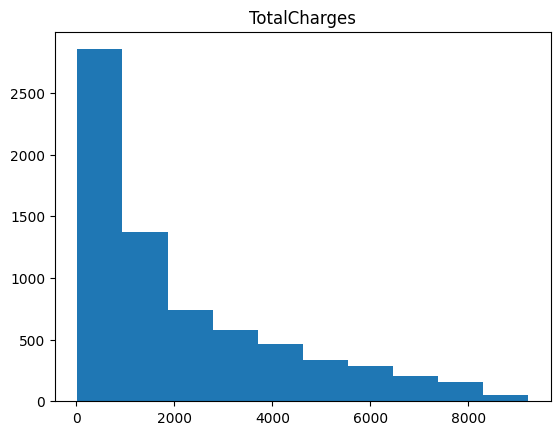

In [22]:
for column in contract.iloc[:, 3:].columns:
    plt.hist(contract[column])
    plt.title(column)
    plt.show()

In [23]:
print((contract['EndDate'] == 'No').sum())
print((contract['EndDate'] != 'No').sum())

5942
1101


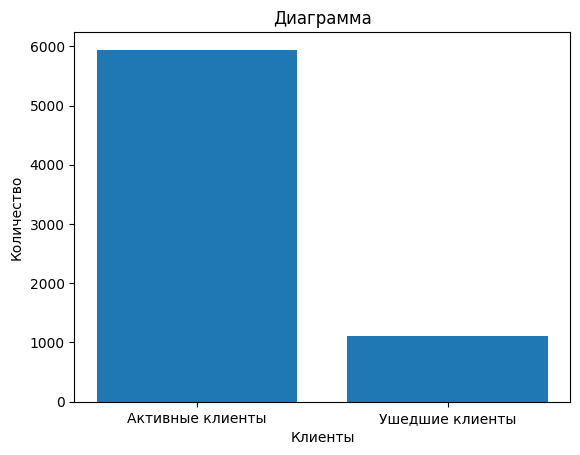

In [24]:
values = [5942, 1101]
plt.bar(['Активные клиенты', 'Ушедшие клиенты'], values)
plt.xlabel('Клиенты')
plt.ylabel('Количество')
plt.title('Диаграмма')
plt.show()

В contract 7042 строки и 8 столбцов, 7 object и 1 float.

In [25]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [26]:
phone.info(), phone.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


(None,
         customerID MultipleLines
 count         6361          6361
 unique        6361             2
 top     5575-GNVDE            No
 freq             1          3390)

In [27]:
phone.isna().sum()

customerID       0
MultipleLines    0
dtype: int64

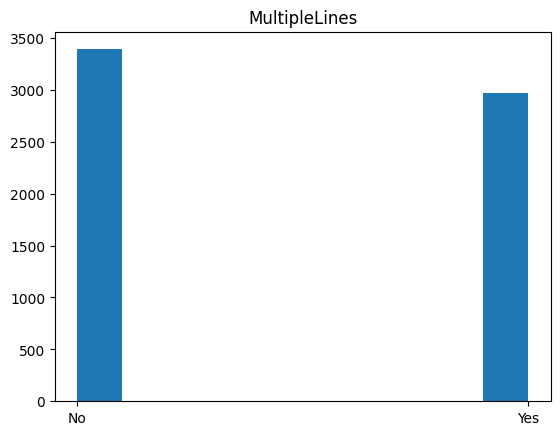

In [28]:
plt.hist(phone['MultipleLines'])
plt.title('MultipleLines')
plt.show()

В phone два столбца object и 6361 строк.

In [29]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [30]:
internet.info(), internet.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


(None,
         customerID InternetService OnlineSecurity OnlineBackup  \
 count         5517            5517           5517         5517   
 unique        5517               2              2            2   
 top     7590-VHVEG     Fiber optic             No           No   
 freq             1            3096           3498         3088   
 
        DeviceProtection TechSupport StreamingTV StreamingMovies  
 count              5517        5517        5517            5517  
 unique                2           2           2               2  
 top                  No          No          No              No  
 freq               3095        3473        2810            2785  )

In [31]:
internet.isna().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

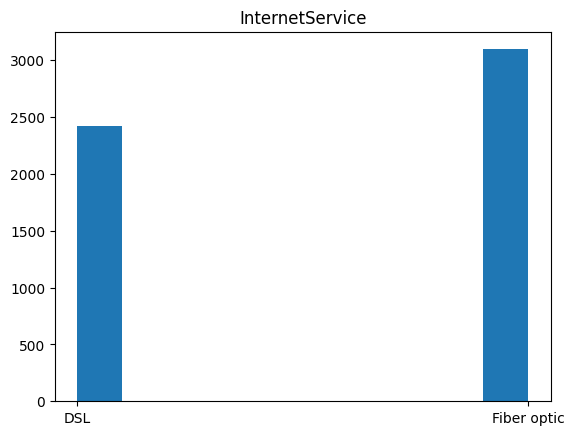

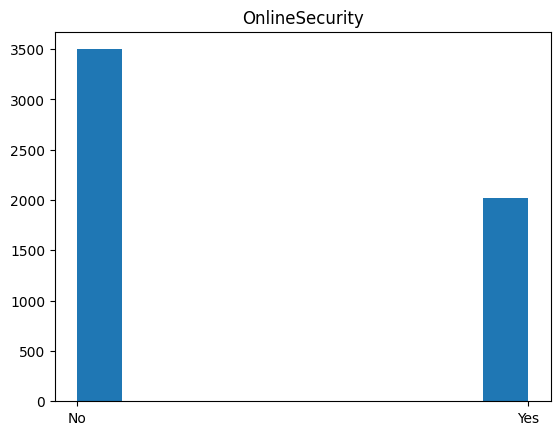

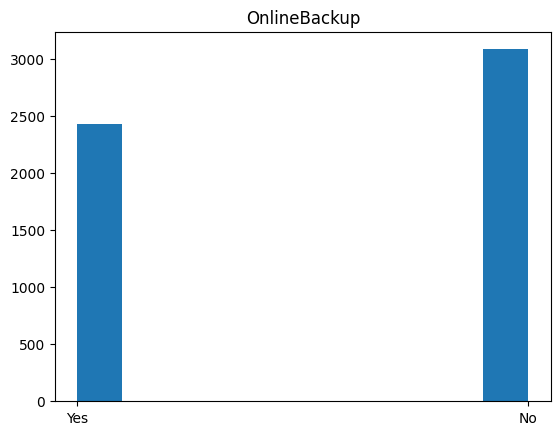

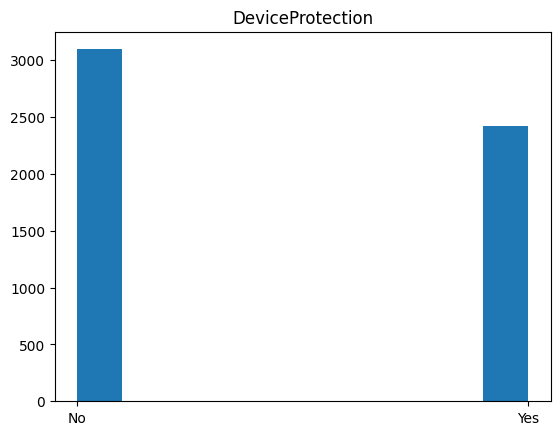

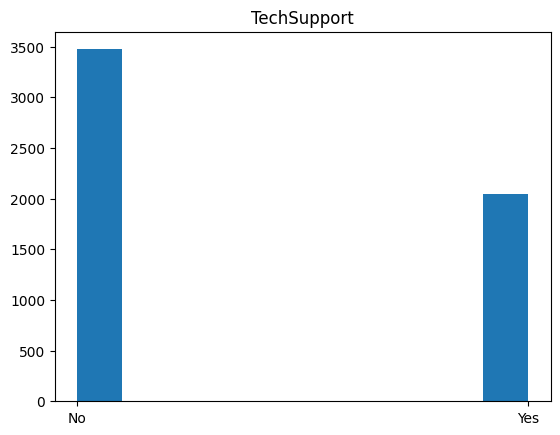

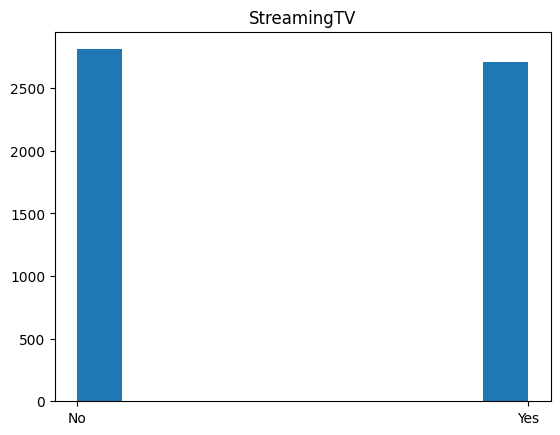

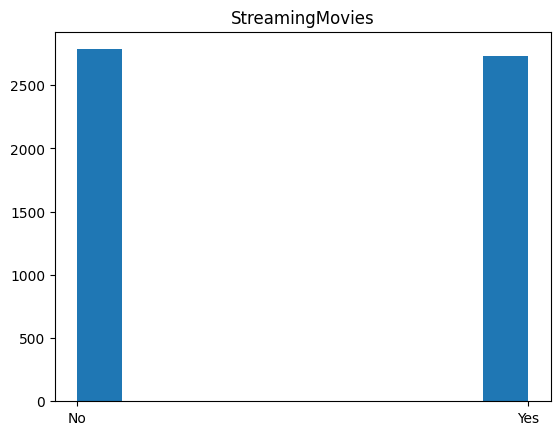

In [32]:
for column in internet.iloc[:, 1:].columns:
    plt.hist(internet[column])
    plt.title(column)
    plt.show()

В internet 8 столбцов object и 5517 строк.

### План проекта
1) Общая информация по проекту  
- описание проекта  
- цель проекта  
- доступные данные  
- выводы по данным  

2) Подготовка данных  
- привести названия столбцов к одному формату (str.lower())  
- преобразовать данные к нужным типам 
- проверить на пропуски 

3) Исследовательский анализ  
- визуализация данных  
- поиск аномалий и выбросов  

4) Обучение моделей    
- Случайный лес  
- Catboost  

5) Выводы:  
- Проверка лучшей модели на тесте  
- Общий вывод по проекту


(Проверка на мультиколлиниарность не планирую, так как модели леса и бустинга невосприимчивы к мультиколлинеарности. Преобразовать категориальные признаки не будем, они не помещают нам обучить модели.)

# Подготовка данных

In [33]:
personal.columns = personal.columns.str.lower()
contract.columns = contract.columns.str.lower()
phone.columns = phone.columns.str.lower()
internet.columns = internet.columns.str.lower()

In [34]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   begindate         7043 non-null   object 
 2   enddate           7043 non-null   object 
 3   type              7043 non-null   object 
 4   paperlessbilling  7043 non-null   object 
 5   paymentmethod     7043 non-null   object 
 6   monthlycharges    7043 non-null   float64
 7   totalcharges      7043 non-null   int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 440.3+ KB


Изменит формат begindate и enddate на datetime и сгенирируем новую фичу с количеством дней контракта. 

In [35]:
contract['begindate'] = pd.to_datetime(contract['begindate'], format='%Y-%m-%d')

In [36]:
contract['enddate'] = contract['enddate'].replace('No', '2020-02-01')

In [37]:
contract['enddate'] = pd.to_datetime(contract['enddate'], format='%Y-%m-%d')

In [38]:
print(personal.duplicated().sum())
print(contract.duplicated().sum())
print(phone.duplicated().sum())
print(internet.duplicated().sum())

0
0
0
0


In [39]:
contract['days'] = contract['enddate'] - contract['begindate']

In [40]:
contract['days'].head()

0     31 days
1   1036 days
2    123 days
3   1371 days
4    153 days
Name: days, dtype: timedelta64[ns]

In [41]:
data = pd.merge(personal, contract, on='customerid',how='left')
data = pd.merge(data, phone, on='customerid',how='left')
data = pd.merge(data, internet, on='customerid',how='left')

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   customerid        7043 non-null   object         
 1   gender            7043 non-null   object         
 2   seniorcitizen     7043 non-null   int64          
 3   partner           7043 non-null   object         
 4   dependents        7043 non-null   object         
 5   begindate         7043 non-null   datetime64[ns] 
 6   enddate           7043 non-null   datetime64[ns] 
 7   type              7043 non-null   object         
 8   paperlessbilling  7043 non-null   object         
 9   paymentmethod     7043 non-null   object         
 10  monthlycharges    7043 non-null   float64        
 11  totalcharges      7043 non-null   int64          
 12  days              7043 non-null   timedelta64[ns]
 13  multiplelines     6361 non-null   object         
 14  internet

Заполним пропуски в стобцах, которые мы взяли из датасета internet.

In [43]:
data.isna().sum()

customerid             0
gender                 0
seniorcitizen          0
partner                0
dependents             0
begindate              0
enddate                0
type                   0
paperlessbilling       0
paymentmethod          0
monthlycharges         0
totalcharges           0
days                   0
multiplelines        682
internetservice     1526
onlinesecurity      1526
onlinebackup        1526
deviceprotection    1526
techsupport         1526
streamingtv         1526
streamingmovies     1526
dtype: int64

In [44]:
data.select_dtypes(include='object').columns

Index(['customerid', 'gender', 'partner', 'dependents', 'type',
       'paperlessbilling', 'paymentmethod', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies'],
      dtype='object')

In [45]:
data['multiplelines'] = data['multiplelines'].fillna('No')

In [46]:
nan=['internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies']

In [47]:
for column in nan:
    data[column] = data[column].fillna('No')

In [48]:
data['totalcharges'].head(10)

0      31
1    2071
2     226
3    1960
4     353
5    1150
6    2058
7     300
8    3573
9    1628
Name: totalcharges, dtype: int64

In [49]:
data.isna().sum()

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
begindate           0
enddate             0
type                0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
days                0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
dtype: int64

Привели названия столбцов к нижнему регистру для удобства, изменили тип данных begindate & enddate на datetime, 

## Исследовательский анализ

Провери наши данные на выбросы.

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   customerid        7043 non-null   object         
 1   gender            7043 non-null   object         
 2   seniorcitizen     7043 non-null   int64          
 3   partner           7043 non-null   object         
 4   dependents        7043 non-null   object         
 5   begindate         7043 non-null   datetime64[ns] 
 6   enddate           7043 non-null   datetime64[ns] 
 7   type              7043 non-null   object         
 8   paperlessbilling  7043 non-null   object         
 9   paymentmethod     7043 non-null   object         
 10  monthlycharges    7043 non-null   float64        
 11  totalcharges      7043 non-null   int64          
 12  days              7043 non-null   timedelta64[ns]
 13  multiplelines     7043 non-null   object         
 14  internet

In [51]:
data['days'].head(10)

0     31 days
1   1036 days
2    123 days
3   1371 days
4    153 days
5    337 days
6    671 days
7    306 days
8    945 days
9    882 days
Name: days, dtype: timedelta64[ns]

In [52]:
data['days'].sort_values(ascending=False)

3439   2314 days
4610   2314 days
4513   2314 days
975    2283 days
3040   2283 days
          ...   
936       0 days
1082      0 days
3331      0 days
4380      0 days
5218      0 days
Name: days, Length: 7043, dtype: timedelta64[ns]

Переведем data['days'] в тип int для удобства

In [53]:
data['days'] = data['days'].astype('timedelta64[D]')

In [54]:
data['days'] = data['days'].astype('int')

Взглянем на графики, проверим на аномалии, выбросы.

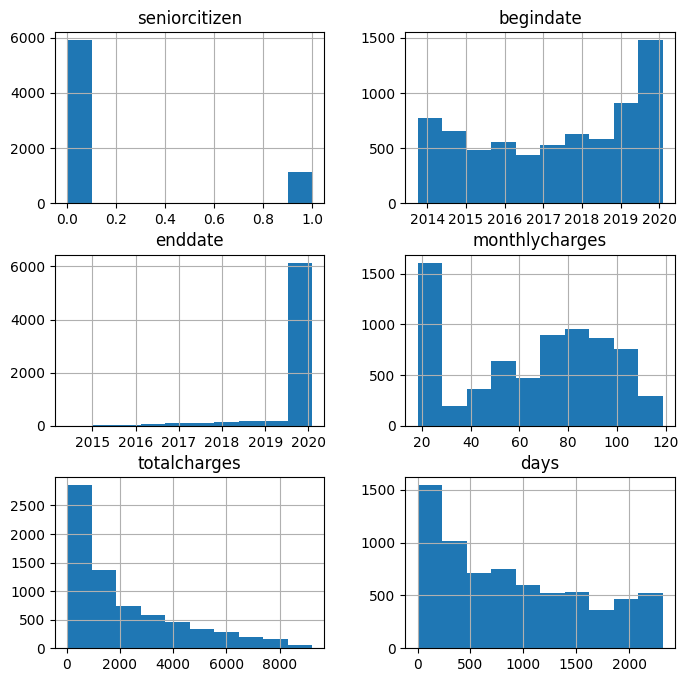

In [55]:
data.hist(figsize=(8,8));

1) В begindate много контрактов в 2020 году  
2) В enddate заглушка, поэтому пик в 2020 году  
3) в monthlycharges можно выделить 3 пика, опционально можно разделить на 3 группы   
4) В totalchrges видно нисходящий тренд, клиентов, которые много платят меньше, что логично.

Text(0, 0.5, 'Количество')

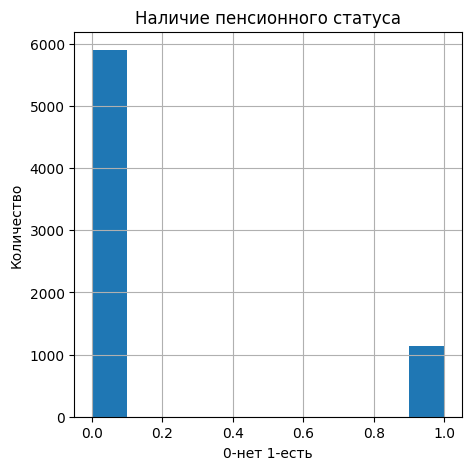

In [56]:
data['seniorcitizen'].hist(figsize=(5,5))
plt.title('Наличие пенсионного статуса')
plt.xlabel('0-нет 1-есть')
plt.ylabel('Количество')

data['seniorcitizen'] - наличие пенсионного статуса по возрасту( 1 - есть статус: 0 - нет статуса)  
преобладает класс людей без пенсионного статусом.  


Text(0, 0.5, 'Количество')

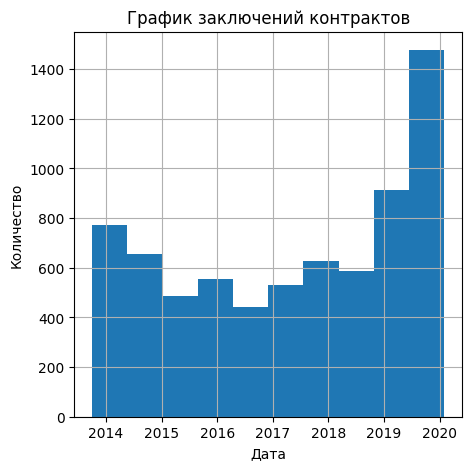

In [57]:
data['begindate'].hist(figsize=(5,5))
plt.title('График заключений контрактов')
plt.xlabel('Дата')
plt.ylabel('Количество')

Количество контрактов в 2020 намного больше, чем за предыдущие года. Так же в 19 году был рост, не думаю, что в данных есть проблемы.

In [58]:
data.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'begindate', 'enddate', 'type', 'paperlessbilling', 'paymentmethod',
       'monthlycharges', 'totalcharges', 'days', 'multiplelines',
       'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies'],
      dtype='object')

In [59]:
data['totalcharges'].sort_values(ascending=True).head(20)

6449    19
1816    19
3457    19
5705    19
3468    19
4242    19
4236    19
3518    19
4221    19
6706    19
1733    19
1654    19
2759    19
1491    19
1168    19
128     19
3852    19
1252    19
1373    19
310     19
Name: totalcharges, dtype: int64

<Axes: >

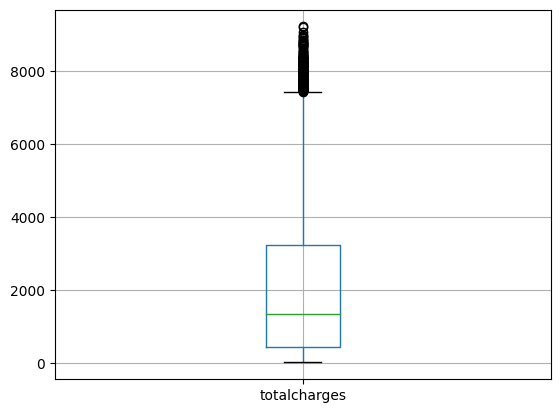

In [60]:
data.boxplot(column=['totalcharges'])

In [61]:
print('В среднем каждый клиент заплатил:', data['totalcharges'].mean())
print('А медиана составила:', data['totalcharges'].median())

В среднем каждый клиент заплатил: 2118.166974300724
А медиана составила: 1349.0


<Axes: >

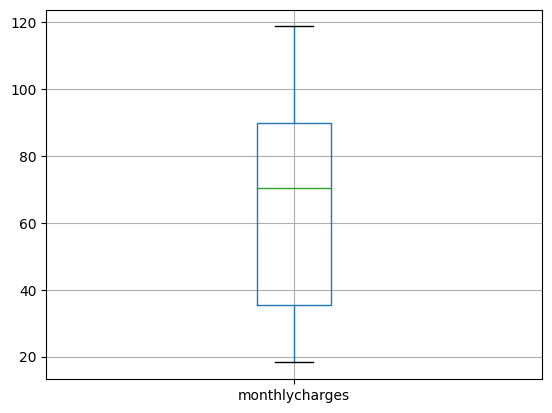

In [62]:
data.boxplot(column=['monthlycharges'])

На диаграмме monthlycharges нет выбросов, медиана смещена чуть вверх. 

In [63]:
data['totalcharges'].sort_values(ascending=True).head(20)

6449    19
1816    19
3457    19
5705    19
3468    19
4242    19
4236    19
3518    19
4221    19
6706    19
1733    19
1654    19
2759    19
1491    19
1168    19
128     19
3852    19
1252    19
1373    19
310     19
Name: totalcharges, dtype: int64

In [64]:
data[data['begindate']== '2020-02-01']['totalcharges']

488     2118
753     2118
936     2118
1082    2118
1340    2118
3331    2118
3826    2118
4380    2118
5218    2118
6670    2118
6754    2118
Name: totalcharges, dtype: int64

в totalcharges стоит заглушка для тех кто стал клиентом в феврале, убирать её не будем.

In [65]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
seniorcitizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
monthlycharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75
totalcharges,7043.0,2118.166974,2111.088362,19.00,440.0,1349.00,3236.00,9221.00
days,7043.0,898.555729,683.130510,0.00,276.0,761.00,1461.00,2314.00


<Axes: >

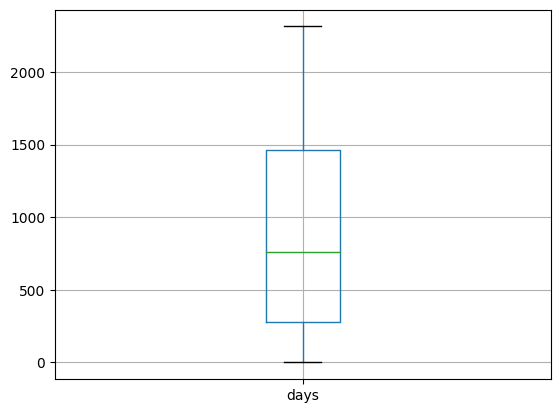

In [66]:
data.boxplot(column=['days'])

In [67]:
sorted_data = data.sort_values(by='totalcharges', ascending=False)
print(sorted_data.loc[:, ['totalcharges', 'monthlycharges']].head(20))

      totalcharges  monthlycharges
4610          9221          117.80
5558          9218          116.40
2559          9068          115.55
4206          8998          116.80
540           8957          113.10
3820          8941          112.90
2689          8910          116.75
2603          8851          114.90
850           8837          115.80
4229          8834          115.75
6728          8788          115.15
745           8775          110.80
1280          8765          114.85
369           8755          112.60
3508          8751          113.65
5197          8723          110.15
6768          8713          117.50
1875          8708          114.10
2368          8687          117.15
5347          8673          116.95


Самый щедрый клиент

In [68]:
data[data['totalcharges'] == 9221]

,customerid,gender,seniorcitizen,partner,dependents,begindate,enddate,type,paperlessbilling,paymentmethod,...,totalcharges,days,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
4610,2889-FPWRM,Male,0,Yes,No,2013-10-01,2020-02-01,One year,Yes,Bank transfer (automatic),...,9221,2314,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes


In [69]:
enddata = data[data['enddate'] !='2020-02-01']


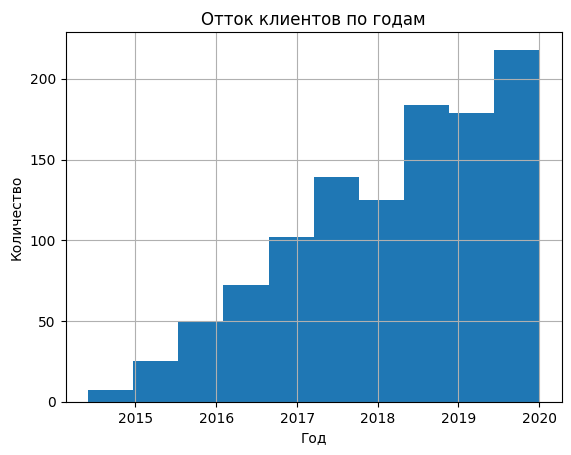

In [70]:
enddata['enddate'].hist()
plt.title('Отток клиентов по годам')
plt.xlabel('Год')
plt.ylabel('Количество');

C каждым годом всё больше и больше клиентов уходят.

In [71]:
data['target'] = (data['enddate'] != "2020-02-01") * 1

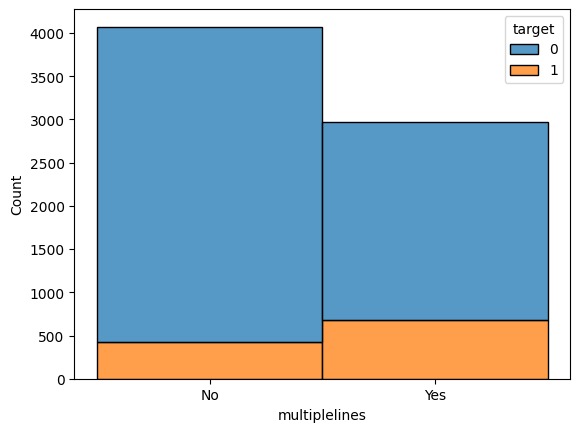

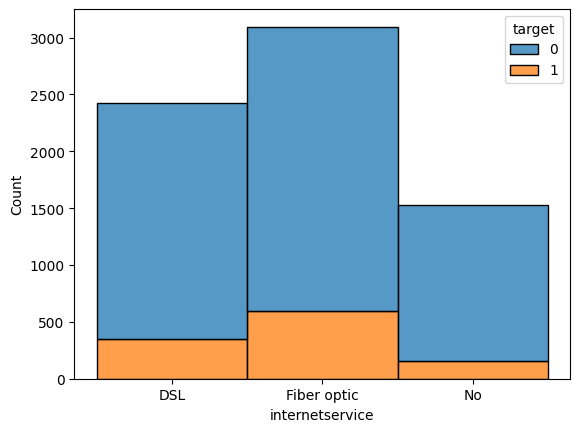

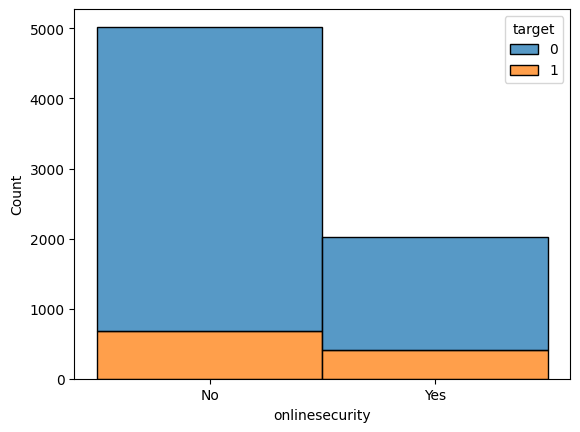

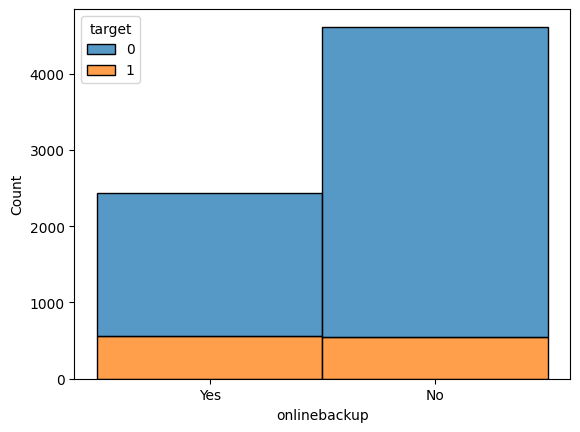

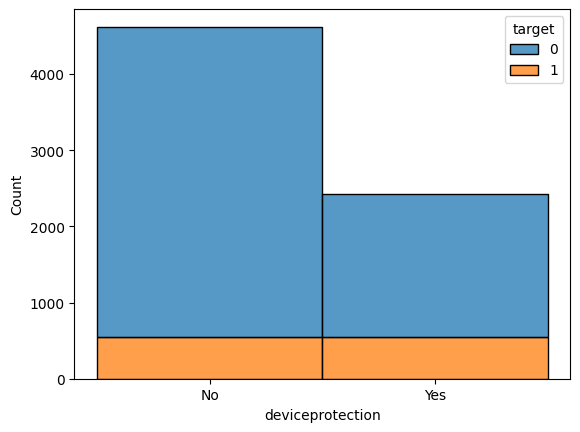

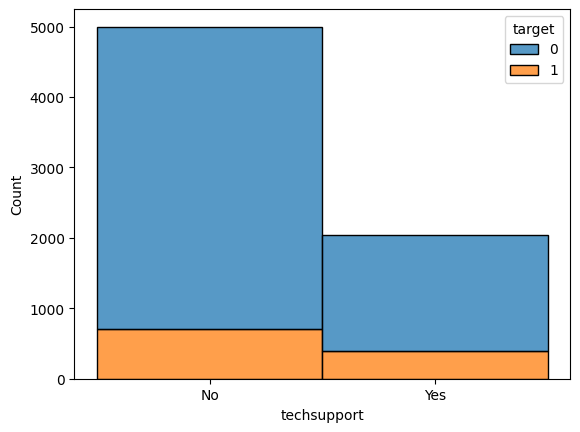

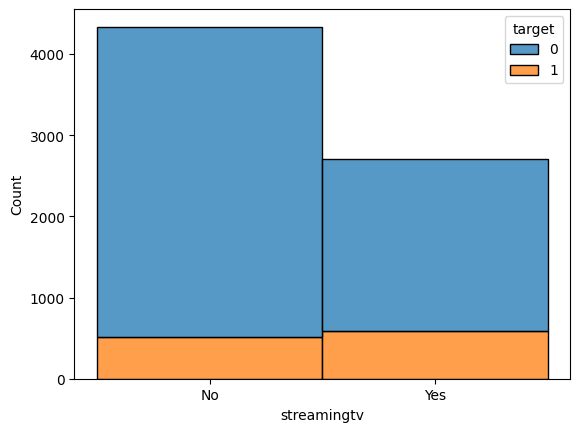

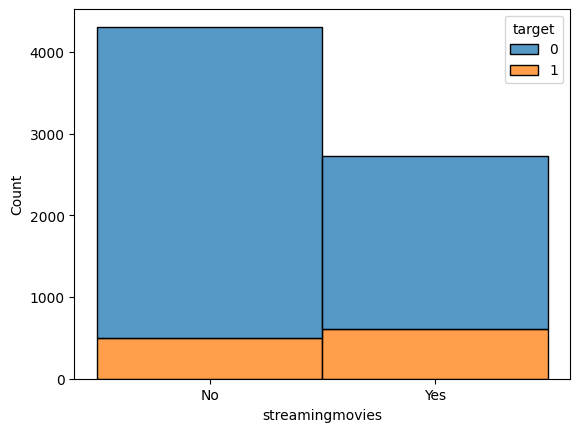

In [72]:

columns = ['multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup',
           'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies']
# Строим графики
for col in columns:
    sns.histplot(data, x=col, hue='target', multiple="stack")
    plt.show()

Много клиентов ушедших от компании, которые пользовались streamingtv и streamingmovies, возможно на это стоит обратить внимание. Чем больше доп. услуг, тем больше шанс ухода клиента.

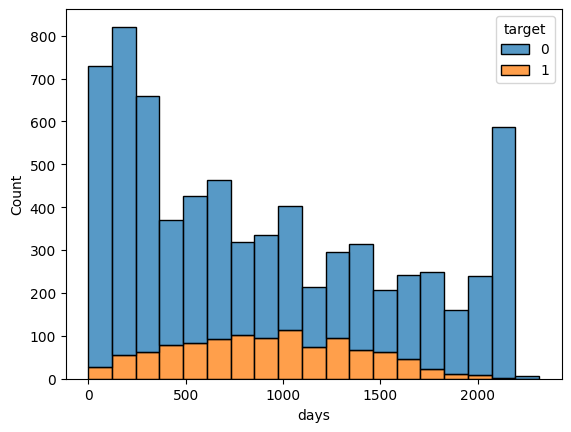

In [73]:
sns.histplot(data, x='days', hue='target', multiple="stack")
plt.show()

Клиенты, которые пользуются услугами около 1000 дней чаще других уходят. 

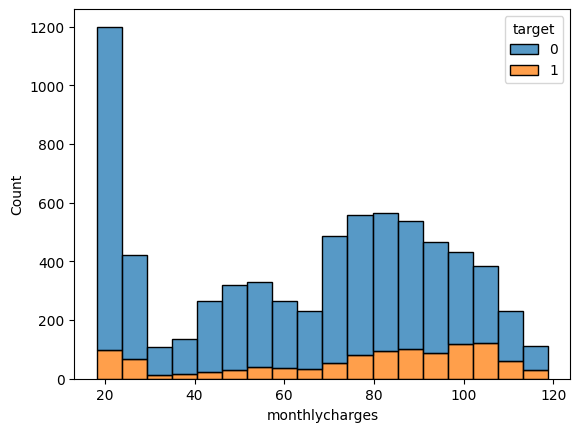

In [74]:
sns.histplot(data, x='monthlycharges', hue='target', multiple="stack")
plt.show()

Чем больше клиент платит, тем больше шанс, что он уйдет.  
Вероятно, что если клиент платит больше 70 и пользуется услугами пару лет,то начинает чаще задуматься об уходе.

In [75]:
drop_columns = ['begindate', 'enddate','customerid']

In [76]:
data.drop(drop_columns, axis=1, inplace=True)


interval columns not set, guessing: ['seniorcitizen', 'monthlycharges', 'totalcharges', 'days', 'target']


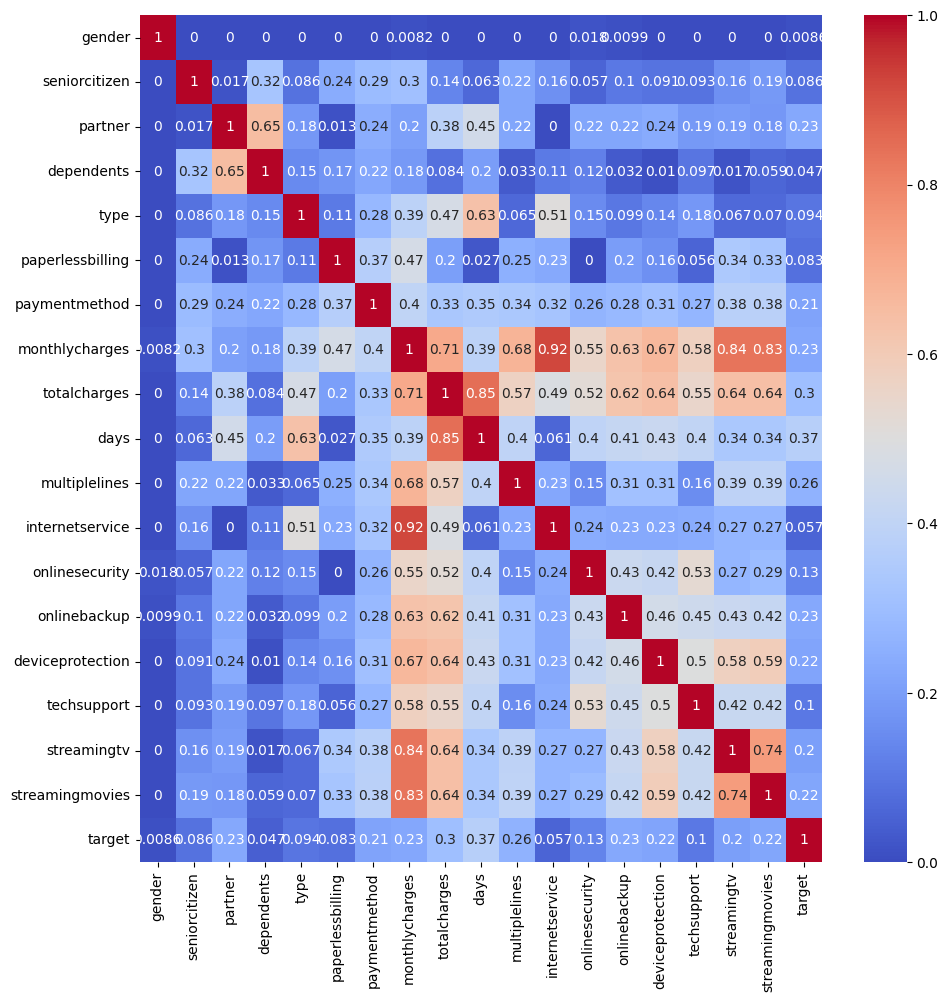

In [77]:
pm = phik_matrix(data)
fig, ax = plt.subplots(figsize=(11, 11), dpi=100)
sns.heatmap(pm, annot=True, cmap='coolwarm', ax=ax);

monthlycharges имеют высокую коллиниарность (больше 0.8) с доп. сервисами streamingmovies, streamingtv и internetservice. В общем все доп. услуги имеет связь monthlycharges и totalcharges, логично, что чем больше клиент платит, тем больше у него доп. услуг.  
Модели случайного леса и catboost невосприимчивы к мультиколлиниарности, поэтому никаких действий не требуется.

Вывод:За последнии годы, стало приходить больше новых клиентов, но и больше уходить. Видно по графику monthlycharges клиентов можно разделить на 3 группы: Обычные пользватели(до 30 в месяц), продвинутые пользватели(до 70 в месяц) и люкс пользователи( от 70 в месяц). Стоблов с признаками не много, избавлятся будем только от customerid(id пользователя не нужен модели), begindate(заменили на days) и enddate(наш таргет). 

## Обучение моделей


### Модель Catboost

Разделим данные на треин и тест.

In [78]:
train, test = train_test_split(data,random_state=RANDOM_STATE)

In [79]:
len(train) / len(data)

0.7499645037626012

Готовим данные для catboost

In [80]:
train.columns

Index(['gender', 'seniorcitizen', 'partner', 'dependents', 'type',
       'paperlessbilling', 'paymentmethod', 'monthlycharges', 'totalcharges',
       'days', 'multiplelines', 'internetservice', 'onlinesecurity',
       'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv',
       'streamingmovies', 'target'],
      dtype='object')

In [81]:
train.select_dtypes(include='object').columns

Index(['gender', 'partner', 'dependents', 'type', 'paperlessbilling',
       'paymentmethod', 'multiplelines', 'internetservice', 'onlinesecurity',
       'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv',
       'streamingmovies'],
      dtype='object')

In [82]:
X = ['gender', 'seniorcitizen', 'partner', 'dependents', 'type',
       'paperlessbilling', 'paymentmethod', 'monthlycharges', 'totalcharges',
       'days', 'multiplelines', 'internetservice', 'onlinesecurity',
       'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv',
       'streamingmovies']

In [83]:
cat_features = ['gender', 'partner', 'dependents', 'type', 'paperlessbilling',
       'paymentmethod', 'multiplelines', 'internetservice', 'onlinesecurity',
       'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv',
       'streamingmovies']

In [84]:
y = ['target']

In [85]:
train_data = Pool(data=train[X],
                  label=train[y],
                  cat_features=cat_features
                 )

In [86]:
test_data = Pool(data=test[X],
                  label=test[y],
                  cat_features=cat_features
                 )

In [87]:
params = {'cat_features': cat_features,
              'eval_metric': 'AUC',
          'loss_function': 'Logloss',
              'learning_rate': 0.1,
              'random_seed': RANDOM_STATE,
              'verbose':100,
         'auto_class_weights':'Balanced'}

Проверим модель на кросс-валидации 

In [88]:
cv_data = cv(
    params = params,
    pool = train_data,
    fold_count=5,
    shuffle=True,
    partition_random_seed=RANDOM_STATE,
    stratified=False,
    verbose=False,
    early_stopping_rounds=200
)

Training on fold [0/5]

bestTest = 0.8975866158
bestIteration = 800

Training on fold [1/5]

bestTest = 0.919989235
bestIteration = 958

Training on fold [2/5]

bestTest = 0.8856569448
bestIteration = 939

Training on fold [3/5]

bestTest = 0.8887910456
bestIteration = 999

Training on fold [4/5]

bestTest = 0.9102256583
bestIteration = 999



In [89]:
cv_data

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.767773,0.029008,0.664246,0.003553,0.661695,0.002592
1,1,0.793743,0.024709,0.640127,0.005233,0.636999,0.002016
2,2,0.804201,0.025620,0.618650,0.007114,0.614343,0.003143
3,3,0.805776,0.024058,0.602171,0.007659,0.595647,0.003412
4,4,0.810228,0.023551,0.591220,0.009813,0.583593,0.006082
...,...,...,...,...,...,...,...
995,995,0.899806,0.014698,0.525007,0.063762,0.053607,0.003281
996,996,0.899820,0.014718,0.525020,0.063797,0.053550,0.003252
997,997,0.899765,0.014709,0.525298,0.063681,0.053509,0.003250
998,998,0.899747,0.014630,0.525500,0.063515,0.053408,0.003174


In [90]:
cv_data[cv_data['test-AUC-mean'] == cv_data['test-AUC-mean'].max()]

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
996,996,0.89982,0.014718,0.52502,0.063797,0.05355,0.003252


Catboost на cv прошел порог в 0.85 AUC-ROC. Можно обучить на всем трейне и проверить на тесте. 

### Случайный лес

In [91]:
features_rf = data.drop(columns=['target'])
target_rf = data['target']

In [92]:
features_rf[cat_features] = features_rf[cat_features].apply(pd.Categorical)

In [93]:
features_rf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7043 non-null   category
 1   seniorcitizen     7043 non-null   int64   
 2   partner           7043 non-null   category
 3   dependents        7043 non-null   category
 4   type              7043 non-null   category
 5   paperlessbilling  7043 non-null   category
 6   paymentmethod     7043 non-null   category
 7   monthlycharges    7043 non-null   float64 
 8   totalcharges      7043 non-null   int64   
 9   days              7043 non-null   int32   
 10  multiplelines     7043 non-null   category
 11  internetservice   7043 non-null   category
 12  onlinesecurity    7043 non-null   category
 13  onlinebackup      7043 non-null   category
 14  deviceprotection  7043 non-null   category
 15  techsupport       7043 non-null   category
 16  streamingtv       7043 n

In [94]:
from sklearn.preprocessing import LabelEncoder

In [95]:
features_rf.select_dtypes(include='category').columns

Index(['gender', 'partner', 'dependents', 'type', 'paperlessbilling',
       'paymentmethod', 'multiplelines', 'internetservice', 'onlinesecurity',
       'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv',
       'streamingmovies'],
      dtype='object')

In [96]:
le = LabelEncoder()
for feature in cat_features:
    features_rf[feature] = le.fit_transform(features_rf[feature])

In [97]:
features_rf.describe()

,gender,seniorcitizen,partner,dependents,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,days,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.504756,0.162147,0.483033,0.299588,0.690473,0.592219,1.574329,64.761692,2118.166974,898.555729,0.421837,0.872923,0.286668,0.344881,0.343888,0.290217,0.384353,0.387903
std,0.500013,0.368612,0.499748,0.458110,0.833755,0.491457,1.068104,30.090047,2111.088362,683.130510,0.493888,0.737796,0.452237,0.475363,0.475038,0.453895,0.486477,0.487307
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,35.500000,440.000000,276.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,70.350000,1349.000000,761.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2.000000,89.850000,3236.000000,1461.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,118.750000,9221.000000,2314.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [98]:
model_rf = RandomForestClassifier(random_state=RANDOM_STATE)

parameters = { 'max_depth': [x for x in range(2, 12, 2)],
               'n_estimators': [x for x in range(100, 250, 10)]
             }

In [99]:
grid_rf_final = GridSearchCV(model_rf, 
                            parameters, 
                            cv=5, 
                            scoring='roc_auc'
                              )
grid_rf_final.fit(features_rf, target_rf)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=30723),
             param_grid={'max_depth': [2, 4, 6, 8, 10],
                         'n_estimators': [100, 110, 120, 130, 140, 150, 160,
                                          170, 180, 190, 200, 210, 220, 230,
                                          240]},
             scoring='roc_auc')

In [100]:
print('Лучшие параметры: ', grid_rf_final.best_params_)
print('ROC-AUC', grid_rf_final.best_score_)

Лучшие параметры:  {'max_depth': 8, 'n_estimators': 230}
ROC-AUC 0.8351771689883751


Случайный лес не прошел порог в 0.85.

### Вывод:
Из двух моделей случайного леса и catboost, прошел порог только catboost. Проверим catboost на трейне.

In [101]:
model = CatBoostClassifier(**params)

In [102]:
model.fit(train_data)

0:	total: 42ms	remaining: 41.9s
100:	total: 4.2s	remaining: 37.3s
200:	total: 9.22s	remaining: 36.6s
300:	total: 14.2s	remaining: 32.9s
400:	total: 19s	remaining: 28.3s
500:	total: 24s	remaining: 23.9s
600:	total: 29.4s	remaining: 19.5s
700:	total: 34.2s	remaining: 14.6s
800:	total: 39s	remaining: 9.68s
900:	total: 44s	remaining: 4.83s
999:	total: 48.7s	remaining: 0us


In [103]:
y_pred_proba = model.predict_proba(test_data)[:, 1]

# Вычисляем ROC AUC на тестовых данных
roc_auc = roc_auc_score(test[y], y_pred_proba)

# Выводим значение ROC AUC на экран
print('ROC AUC:', roc_auc)

ROC AUC: 0.9134808853118712


Модель catboost смогла на тесте показать результат ROC-AUC = 0.91, что полностью нас устраивает. 

In [104]:
from sklearn.metrics import accuracy_score, confusion_matrix


y_pred = (y_pred_proba > 0.5).astype(int)
accuracy = accuracy_score(test[y], y_pred)

print('Accuracy:', accuracy)

cm = confusion_matrix(test[y], y_pred)

print('Confusion Matrix:\n', cm)

Accuracy: 0.8983532084043158
Confusion Matrix:
 [[1386   91]
 [  88  196]]


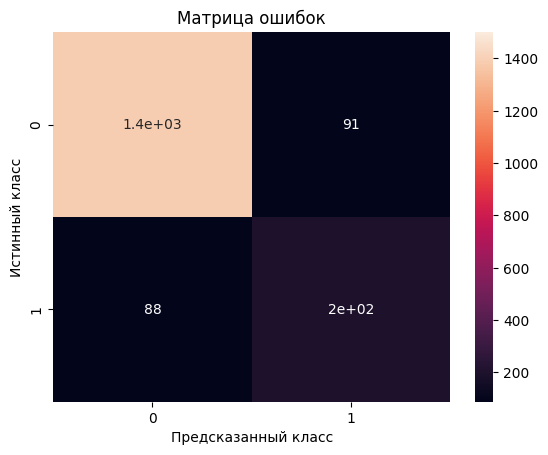

In [105]:
sns.heatmap(pd.DataFrame(cm), annot=True, vmax=1500)
plt.title('Матрица ошибок')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()

Неверно пресказаных 0 и 1 примерно одно и тоже, но для бизнеса критичнее ошибка второго рода, таких 91.

In [106]:
fpr, tpr, thresholds = roc_curve(test[y], y_pred_proba)

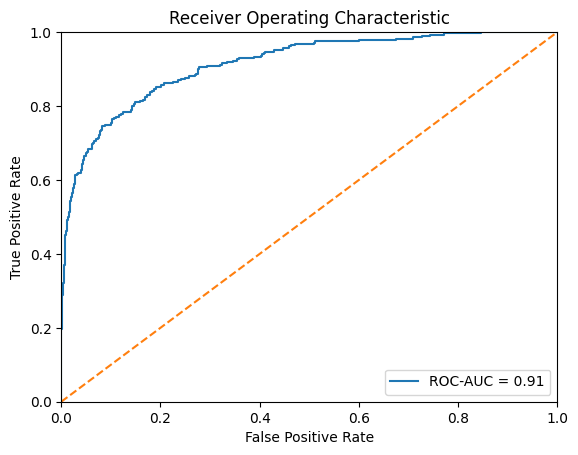

In [107]:
plt.plot(fpr, tpr, label='ROC-AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [108]:
feature_importances = pd.DataFrame({'Признак': data[X].columns, 'Важность признака': model.feature_importances_})

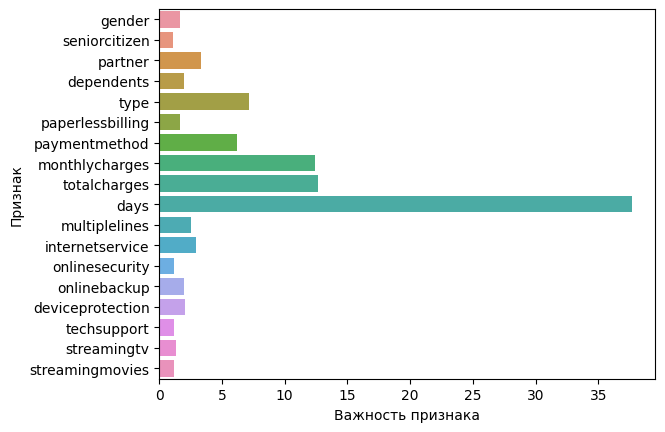

In [109]:
sns.barplot(x='Важность признака', y='Признак', data=feature_importances, orient='h')
plt.show()

Основными признаки, по котрыми искать возможных уходящих клиентов: длительность контрака, суммы затрат клиента и тип оплаты.

## Общий вывод

При работе над проектом мы рассмотрели 4 таблицы:  
Описание данных  
Данные состоят из файлов, полученных из разных источников:  
• contract_new.csv — информация о договоре;  
• personal_new.csv — персональные данные клиента;  
• internet_new.csv — информация об интернет-услугах;  
• phone_new.csv — информация об услугах телефонии  
  
В первой части нашей работы мы ознакомились с данными всего было представленно 7043 записи с клиентами. Явных пропусков и дубликатов не обнаружили.

В процессе изучения и предобработки данных:
Неявные пропуски в totalcharges,
Неверный тип у begindate привели к datetime;
В enddate поставили заглушку вместо 'No' поставили дату актуальности датасета - 2020-02-01.
После предобработки объеденили всё в один датафрейм.

Бустинговая модель catboost смогла пройти порог в 0.85 ROC-AUC на трейне. Результат в 0.91 ROC на тесте удовлетворителен. Модель можно использовать для поиска потенциально уходящего клиента. 

## Отчет

Задача проекта: спрогнозировать отток клиентов в телекоммуникационной компании.  
Работе шла согласно плану:  
На первом этапе мы загрузили и ознакомились с 4 датасетами, провели предварительный анализ данных, сформулировали цель и составили план работ.  
На втором этапе мы подготавливали данные привели названия столбцов к одному формату, преобразовали данные к нужным для работы типам, проверили и заменили пропуски. Объеденили 4 дата сета в один датасет(data) с 21 столбцом и 7042 строками, также на этом этапе добавили столбец с количеством дней клиента в компании(days).    
На третьем этапе мы занимались визуализацией данных и поиском аномалий и выбросов. Строили гистограммы и boxplot, в добавили heatmap корреляций признаков, который не входил в наш план вначале. Изучили графики и сделали выводы.  
На четвертом этапе мы занимались обучение двух моделей: случайного леса и catboost. Для catboost мы создали pool перед обучением, а для случайного леса кодировали категориальные признаки. Модели обучались на 18 признаках. Результаты моделей на трейне: catboost: AUC-90, случайный лес: AUC-83. Порог в 0.85 прошле только catboost.    
На завершающем этапе мы обучили модель на трейне и проверили на тесте catboost и получили результат AUC-91. Написали общий вывод по работе.  
  
  
  
Список признаков, которые использовали для обучения моделей: 'gender', 'seniorcitizen', 'partner', 'dependents', 'type', paperlessbilling', 'paymentmethod', 'monthlycharges', 'totalcharges','days', 'multiplelines', 'internetservice', 'onlinesecurity','onlinebackup', 'deviceprotection', 'techsupport','streamingtv','streamingmovies'  
  
Итоговая модель: catboost  
Параметры модели:  
'cat_features': cat_features,  
              'eval_metric': 'AUC',  
          'loss_function': 'Logloss',  
              'learning_rate': 0.1,  
              'random_seed': 30723,
              'verbose':100,  
         'auto_class_weights':'Balanced'  
         
Отличия от основного плана: Добавили heatmap коррелияций, использовали pool для catboost и кодирование категориальных признаков для случайного леса.  
  
Трудности возникли на этапе подготовки данных для случайного леса.  
Считаю все этапы работы от ознакомления до написания вывода по работе важными, в работе нельзя отказаться от исследовательского анализа или от предобработки.  
  
  Размер тестовой выборки - 0.25(1761 строка)  
  random_state = 30723  
  
